In [1]:
import tensorflow as tf 
tf.enable_eager_execution()
tf.random.set_random_seed(48)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle 

import itertools

In [3]:
training_set = np.load("linear_classifier_train/VAE_Training_Linear.npy")
testing_set = np.load("linear_classifier_train/VAE_Testing_Linear.npy")

In [4]:
training_label = pickle.load(open('linear_classifier_train/VAE_Training_Linear_label.pkl', 'rb'))
testing_label = pickle.load(open('linear_classifier_train/VAE_Testing_Linear_label.pkl', 'rb'))

In [5]:
training_label = [t-1 for t in training_label]
testing_label = [t-1 for t in testing_label]

In [6]:
TRAIN_BUF = 50000
BATCH_SIZE = 32

In [7]:
assert len(training_label) == training_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((training_set, training_label)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [8]:
class Classifier(tf.keras.Model):
    """Same Architecture"""
    def __init__(self):
        super().__init__()
        self.layer = tf.keras.layers.Dense(5)
        
    def call(self, latent):
        layer_out = self.layer(latent)
        return layer_out, tf.nn.softmax(layer_out)

In [9]:
classifier = Classifier()
optimizer = tf.train.AdamOptimizer(5e-5)

In [10]:
for epoch in range(40):
    print(f"At epoch {epoch}")
    for i, (data, label) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(classifier.variables)
            
            out, _ = classifier(data)
            label = tf.expand_dims(label, axis=-1)
            loss = tf.losses.sparse_softmax_cross_entropy(labels=label, logits=out)
            loss = tf.reduce_mean(loss)
            
            if i % 1000 == 0:
                print(loss)
        grad = tape.gradient(loss, classifier.variables)
        optimizer.apply_gradients(zip(grad, classifier.variables))
    print(f"---------")

At epoch 0
tf.Tensor(2.4714499, shape=(), dtype=float32)
tf.Tensor(1.8924434, shape=(), dtype=float32)
---------
At epoch 1
tf.Tensor(1.785587, shape=(), dtype=float32)
tf.Tensor(1.5356181, shape=(), dtype=float32)
---------
At epoch 2
tf.Tensor(1.5164397, shape=(), dtype=float32)
tf.Tensor(1.4142795, shape=(), dtype=float32)
---------
At epoch 3
tf.Tensor(1.42574, shape=(), dtype=float32)
tf.Tensor(1.3615053, shape=(), dtype=float32)
---------
At epoch 4
tf.Tensor(1.3673112, shape=(), dtype=float32)
tf.Tensor(1.3151616, shape=(), dtype=float32)
---------
At epoch 5
tf.Tensor(1.3119422, shape=(), dtype=float32)
tf.Tensor(1.270907, shape=(), dtype=float32)
---------
At epoch 6
tf.Tensor(1.2587487, shape=(), dtype=float32)
tf.Tensor(1.2287319, shape=(), dtype=float32)
---------
At epoch 7
tf.Tensor(1.2079842, shape=(), dtype=float32)
tf.Tensor(1.1886506, shape=(), dtype=float32)
---------
At epoch 8
tf.Tensor(1.1597064, shape=(), dtype=float32)
tf.Tensor(1.1506293, shape=(), dtype=float3

In [11]:
_, out_test = classifier(tf.convert_to_tensor(testing_set))
all_labels = tf.argmax(out_test, axis=1).numpy()
testing_label = np.array(testing_label)

In [12]:
# testing_label.shape 
acc = np.sum(np.equal(all_labels, testing_label))/testing_label.shape[0]
print(f"Accuracy: {acc*100}%")

Accuracy: 77.7%


In [13]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 433  199  364    3    1]
 [  26  898   73    1    2]
 [ 383   59  554    3    1]
 [   0    0    0 1000    0]
 [   0    0    0    0 1000]]


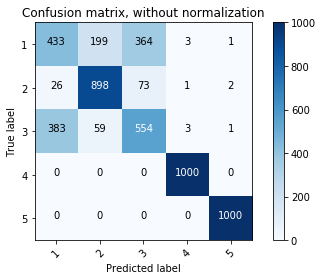

In [14]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(testing_label, all_labels), 
                      classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix, without normalization')